# FORTRAN TEST PROBLEMS

# Project Files:
## 1. usnc.py - Module designed for USNC for curve fitting
## 2. MainProgram.model - Standard Fortran Code that needs to be written 
## 3. Calibration Environment Jupyter Notebook
## 4. Test1.inp - Test5.inp
## Output File Generated: FOTRANFILE ***(default=umat.f)*** and stored in path specified by *FORTRANPATH*
# Software Requirements:
## Python Anaconda 3.5: <https://www.continuum.io/downloads>
# -----------------------------------------------------------------------

# Two Stages of Fitting of Creep Data:
## 1. Scalar Material Properties, *Youngs Modulus, Linear Dimensional Change and Coefficient of Thermal Expansion*, Are Individually Fitted
## 2. Primary and Secondary Creep Models Are Fitted on the Total Creep Strain Data
# -----------------------------------------------------------------------
## Units are assumed as follows:
## 1. *Temperature* degC
## 2. *Fluence* (dpa)
## 3. *Force* (N)
## 4. *Stress* (MPa)
## 5. *Length* (mm)
## 6. *Time* defined by usnc.GetGetTempPosTimeCode and usnc.GetFluencePosTimeCode as they are the only functions that depend on time

In [1]:
# Loading Required Modules and Setting Up the Plotting Environment
%matplotlib notebook
import usnc
import os
from sympy import symbols, exp,  IndexedBase
import numpy as np
from sympy.utilities.codegen import codegen
from numpy import matrix, exp
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy.printing import fcode
from sklearn.metrics.regression import r2_score, explained_variance_score, mean_absolute_error, median_absolute_error
from scipy.interpolate import interp1d

# Choice for units are Temperature (degC), Fluence (dpa) Force (N), Stress (Pa) and length (m)
# Adjust units accordingly and convert data to be consistent with a FEM package 
NOTEBOOKPATH = r'C:\Users\Michael Hindley\Dropbox (USNC-SA)\04 USNC_Reactor Systems\03 Equipment Design\Core Graphite Assembly\Notebook_For_Export'
os.chdir(NOTEBOOKPATH)
# NAME OF THE DATASET
DATASET = 'HAAG.xls'
# PATH WHERE CALCULIX SOURCE CODE IS LOCATED
FORTRANPATH = r'C:\Users\Michael Hindley\Dropbox (USNC-SA)\04 USNC_Reactor Systems\03 Equipment Design\Core Graphite Assembly\Notebook_For_Export'
# NAME OF THE CALCULIX EXECUTABLE
CCXNAME = 'ccx_2.12'
# NAME OF THE FORTRAN MATERIAL FILE
FORTRANFILE = "umat.f"
# NAME WHERE ANSYS FILE SHOULD BE WRITTEN TO
ANSYSPATH = r'C:\Users\Michael Hindley\Dropbox (USNC-SA)\04 USNC_Reactor Systems\03 Equipment Design\Core Graphite Assembly\Notebook_For_Export'
# NAME OF THE ANSYS MATERIAL FILE
ANSYSFILE = "usermat.F"
# PATH WHERE THE DATASET AND TESTS*.INP ARE LOCATED
DATAPATH = r'C:\Users\Michael Hindley\Dropbox (USNC-SA)\04 USNC_Reactor Systems\03 Equipment Design\Core Graphite Assembly\Notebook_For_Export'


# Define the properties for the three canonical directions 
D1 = 'par';D2 = 'par';D3 = 'per'
# Define material properties (v = Poisson ratio, G1,G2,G3 Shear Modulus (Pa))
v = 0.15; G1 = 2E3; G2 = 2E3; G3 = 2E3;
# Define stress free temperature for computing thermal strains
Ti = 20.0

# Primary and Secondary Creep Fitting Data and Parameters
# Initial Guess for Primary and Secondary Creep Parameters
PCREEP = np.array([5.44550279 , 2.25226513 , 0.81541919])
NumPointsCreepIntegration = 101

# Stress state at which experimental data and tests were conducted
stress1 = np.array([5,0,0,0,0,0])
stress2 = np.array([5,0,0,0,0,0])

# Initial primary (Ecp1) and secondary creep (Ecs1)
Ecp1 = np.array([0,0,0,0,0,0])
Ecs1 = np.array([0,0,0,0,0,0])

# Select E0par and E0per that accounts for the manufacturing variability
# Suggestion is to run the min and max to obtain statisical variance in response
tE0per,fE0per,E0perVec = usnc.loadColumn(DATASET,'PerpExtrusion','Pre-Irrad.Eo(GPa)');
E0perVec*1E3 # Convert GPa to MPa
tE0par,fE0par,E0parVec = usnc.loadColumn(DATASET,'ParExtrusion','Pre-Irrad.Eo(GPa)');
E0parVec*1E3 # Convert GPa to MPa

# Comment and Uncomment as appropriate
#E0per = np.max(E0perVec)
#E0per = np.min(E0perVec)
E0per = np.mean(E0perVec)

#E0par = np.max(E0parVec)
#E0par = np.min(E0parVec)
E0par = np.mean(E0parVec)


# Calibration environment for temperature and fluence dependent creep behavior of materials
### The **form** for a material model is indicated by a string that contains reference to temperature, fluence and material parameters:
1. Temperature is indicated by the symbol T
2. Fluence is indicated by te symbol F
3. Parameters are indicated by a list P, with P[i] indicating the ith entry in the list

### The material parameters P need to be characterized given experimental data at specific temperature and fluences.
### To assist the material characterization a module usnc has been developed, which is available by following:
* ensuring usnc.py is in the same directory as the jupyter-notebook
* typing import usnc
* usnc. <TAB> highlights all available functions
* help(usnc.fitlogmodel) displays the help on how to use a function.

### Note: Functions of importance in usnc:
1. usnc.loadColumn -> retrives a column from a specifed spreadsheet in a specified Excel workbook.
2. usnc.fitlogmodel -> fits the log of the data to a model specified by form and returns the model as the first of three output arguments. This ensures the response is always positive in addition to allow for improved robustness in fitting 
a model. The constructed model returns the data transformed back from the log to the normal domain. The other two output arguments are the values of the parameters as well as a Fortran function for the fitted model.
3. usnc.fitmodel -> firs the data to a model specified by form and returns the model as the first of three output arguments.

### Uniaxial models required to be fitted for the creep material model:
1. Youngs Modulus [Eperp (GPa)] (Perpendicular direction)
2. Youngs Modulus [Epar (GPa)] (Parallel direction)
3. Linear Dimensional Change [DLPerp] (Perpendicular direction)
4. Linear Dimensional Change [DLPar] (Parallel direction)
5. Coefficient of Thermal Expansion [CTEPerp] (Perpendicular direction)
6. Coefficient of Thermal Expansion [CTEPar] (Parallel direction)

In [2]:
# Symbolic variables T & F to define functions to be fitted with parameters indicated by P[#]
T,F = symbols('T,F')
form1 = 'F*(P[0] + P[1]*F + P[2]*F**2 + P[3]*T + P[4]*F*T**2 + P[5]*F**3 + P[6]*F**3*T)'
form2 = 'F*(P[0] + P[1]*T + P[2]*F + P[3]*T*F + P[4]*T**2 + P[5]*F**2 + P[6]*T**3+ P[7]*F**3 + P[8]*T**2*F + P[9]*T*F**2)'
form3 = '(P[0] + P[1]*T + P[2]*F + P[3]*T*F + P[4]*T**2 + P[5]*F**2 + P[6]*T**3+ P[7]*F**3 + P[8]*T**2*F + P[9]*T*F**2)'
form4 = '(P[0] + P[1]*T + P[2]*F + P[3]*T*F + P[4]*F**2 + P[5]*F**3 + P[6]*T**2*F + P[7]*T*F**2)'
formCTE0 = 'P[0] + P[1]*T + P[2]*T**2'

formE = 'P[0]'

# Load from FILENAME on an Excel Worksheet a specified Column of Data in addition to the Temperature and Fluence
# O1,O2,O3 = LOADCOLUMN(I1,I2,I3)
# 
# O1 Temperature
# O2 Fluence
# O3 Column specified by I3
#
# I1 Filename of the Excel Workbook
# I2 Name of the Worksheet
# I3 Name of the Column to be Loaded
#
# ------------------------------------------------------------
#
# O1,O2,O3 = usnc.fitmodelfunc(I1,I2,I3,I4,I5,I6)
# Response (I3) is fitted as specified in I3 without any transformation 
#
# O1. Generated Python Function (T,F)
# O2. Optimally Fitted Parameters with the number defined by I5 and I6
# O3. Generated Fortran Code with name specified by I4
#
# I1. Temperature,
# I2. Fluence,
# I3. Response to be fitted,
# I4. Name of the Fortran Function to be generated as O3
# I5. Form of the function to be fitted with I6 number of parameters
# I6. Number of parameters in the form specified by I5

# Available Fitting Functions (Response over Time and Fluence) are:
# 1. usnc.fitmodelfunc - fit model specified by form to the response (third argument) 
# 2. usnc.fitlogmodelfunc - fit model specified by form after transforming Response to log10 domain 
# All returned output is scaled back to the original domain from the log10 domain
#
# ------------------------------------------------------------
#
# Against Grain is indicated by per (perpendicular)
# With Grain is indicated by par (parallel)
 
E0per = E0per*1E3 # Convert GPa to MPa
CodeE0per = usnc.setconstantsub(E0per,'GetE0per')

tEE0per,fEE0per,EpE0per = usnc.loadColumn(DATASET,'PerpExtrusion','E/EoPre-Irrad.');
EpE0per = EpE0per
GetEoverE0per,XEoverE0per,CodeEoverE0per = usnc.fitlogmodel(tEE0per,fEE0per,EpE0per,'GetEoverE0per',form1,7)

E0par = E0par*1E3 # Convert GPa to MPa
CodeE0par = usnc.setconstantsub(E0par,'GetE0par')

tEE0par,fEE0par,EpE0par = usnc.loadColumn(DATASET,'ParExtrusion','E/EoPre-Irrad.');
EpE0par = EpE0par 
GetEoverE0par,XEoverE0par,CodeEoverE0par = usnc.fitlogmodel(tEE0par,fEE0par,EpE0par,'GetEoverE0par',form1,7)


# Wiegner Strain / Linear Dimensional Change
tDLpar,fDLpar,DLpar = usnc.loadColumn(DATASET,'ParExtrusion','LinearDimensionalChangesDl/l0(%)')
YDLpar = DLpar/100. # Data is in percentage
GetDLpar,XDLpar,CodeDLpar = usnc.fitmodel(tDLpar,fDLpar,YDLpar,'Get_Wigner_par',form4,8)

tDLper,fDLper,DLper = usnc.loadColumn(DATASET,'PerpExtrusion','LinearDimensionalChangesDl/l0(%)')
YDLper = DLper/100. # Data is in percentage
GetDLper,XDLper,CodeDLper = usnc.fitmodel(tDLper,fDLper,YDLper,'Get_Wigner_per',form4,8)

# Coefficient of Thermal Expansion (CTE)
#tCTEpar,fCTEpar,CTEpar0 = usnc.loadColumn(DATASET,'ParExtrusion','Pre-Irrad.CTE0(10-6/K)')
#tCTEpar,fCTEpar,CTEpar = usnc.loadColumn(DATASET,'ParExtrusion','DCTE/CTE0(%)')
#YCTEpar = CTEpar0*CTEpar/100.*1E-6 # One data set is in percentage while the other in units 1E-6
#GetCTEpar,XCTEpar,CodeCTEpar = usnc.fitmodel(tCTEpar,fCTEpar,YCTEpar,'Get_CTE_par',form3,10)

tCTE0par,fCTE0par,CTEpar0 = usnc.loadColumn(DATASET,'ParExtrusion','Pre-Irrad.CTE0(10-6/K)')
YCTE0par = CTEpar0*1E-6
GetCTE0par,XCTE0par,CodeCTE0par = usnc.fit1Dlogmodel(tCTE0par,YCTE0par,'Get_CTE0par',formCTE0,3)
tCTEoCTE0par,fCTEoCTE0par,CTEoCTE0par = usnc.loadColumn(DATASET,'ParExtrusion','DCTE/CTE0(%)')
YCTEoCTE0par = CTEoCTE0par/100 # One data set is in percentage while the other in units 1E-6
GetCTEoCTE0par,XCTEpar,CodeCTEoCTE0par = usnc.fitmodel(tCTEoCTE0par,fCTEoCTE0par,YCTEoCTE0par,'Get_CTEoCTE0par',form4,8)

tCTE0per,fCTE0per,CTEper0 = usnc.loadColumn(DATASET,'PerpExtrusion','Pre-Irrad.CTE0(10-6/K)')
YCTE0per = CTEper0*1E-6
GetCTE0per,XDXCTE0per,CodeCTE0per = usnc.fit1Dlogmodel(tCTE0per,YCTE0per,'Get_CTE0per',formCTE0,3)
tCTEoCTE0per,fCTEoCTE0per,CTEoCTE0per = usnc.loadColumn(DATASET,'PerpExtrusion','DCTE/CTE0(%)')
YCTEoCTE0per = CTEoCTE0per/100 # One data set is in percentage while the other in units 1E-6
GetCTEoCTE0per,XCTEper,CodeCTEoCTE0per = usnc.fitmodel(tCTEoCTE0per,fCTEoCTE0per,YCTEoCTE0per,'Get_CTEoCTE0per',form4,8)

tCON,fCON,CON = usnc.loadColumn(DATASET,'Conductivity','ThermalConductivity(W/cmK)')
dummy1,dummy2,CONorient = usnc.loadColumn(DATASET,'Conductivity','Orientation(withregardtoextrudingdirection)')

tCONpar = tCON[np.array(CONorient=='parallel')]
fCONpar = fCON[np.array(CONorient=='parallel')]
CONpar = CON[np.array(CONorient=='parallel')]
GetCONpar,XCONpar,CodeCONpar = usnc.fitlogmodel(tCONpar,fCONpar,CONpar,'Get_Conductivity_par',form4,8)

tCONper = tCON[np.array(CONorient=='perpendicular')]
fCONper = fCON[np.array(CONorient=='perpendicular')]
CONper = CON[np.array(CONorient=='perpendicular')]

GetCONper,XCONper,CodeCONper = usnc.fitlogmodel(tCONper,fCONper,CONper,'Get_Conductivity_per',form4,8)

# Capture a list of minimum and maximum temperatures and fluences to generate extrapolation warning code
TminVec = [tEE0par.min(),tDLpar.min(),tDLper.min(),tCTE0per.min(),tCTE0par.min(),tCTEoCTE0per.min(),tCTEoCTE0par.min()]
TmaxVec = [tEE0par.max(),tDLpar.max(),tDLper.max(),tCTE0per.max(),tCTE0par.max(),tCTEoCTE0per.max(),tCTEoCTE0par.max()]
FminVec = [fEE0par.min(),fDLpar.min(),fDLper.min(),tCTEoCTE0per.min(),tCTEoCTE0par.min()]
FmaxVec = [fEE0par.max(),fDLpar.max(),fDLper.max(),tCTEoCTE0per.max(),tCTEoCTE0par.max()]

# Quality of the FITS Go To Bottom of Notebook to Section *Plot Control Scalar Functions*

# Uncomment to see Fortran Generated Code
#print(CodeE0per)
#print(CodeEoverE0per)
#print(CodeE0par)
#print(CodeEoverE0par)
#print(CODEDLPar)
#print(CODEDLPer)
print(CodeCTEoCTE0per)
print(CodeCTEoCTE0par)
#print(CodeCONper)

      subroutine Get_CTEoCTE0per(To,Fo,Answer)
!*************************************************************************
! This subroutine computes the wigner strain in the perpendicular direction
! Input  : To      : Temperature
!          Fo      : Fluence
! Output : dL_per : Wigner strain in perpendicular direction
      implicit none
      integer i,j
      real*8 To,Fo,Answer
      real*8 T,F,Tmin,Tmax,Fmin,Fmax

      Tmin = 300.000000000000d0
      Tmax = 607.000000000000d0
      Fmin = 0.0d0
      Fmax = 38.4500000000000d0

      T = (To-Tmin)/(Tmax-Tmin)
      F = (Fo-Fmin)/(Fmax-Fmin)

      Answer = 2.20933670290497d0*F**3 + 2.20370215452895d0*F**2*T -
     @ 3.22093909399339d0*F**2 + 0.413079457746841d0*F*T**2 -
     @ 2.06932252922739d0*F*T + 0.324400147039732d0*F -
     @ 0.0150028207780634d0*T + 0.335393241785611d0
      return
      end

      subroutine Get_CTEoCTE0par(To,Fo,Answer)
!*************************************************************************
! This subr

### Inverse Elastic Constitutive Tensor

* Define Poisson's ratio (v) manually

In [3]:
#Define Elastic Material Matrix 
MatrixD = ("[[1/E{},-{}*1/E{},-{}*1/E{},0,0,0],".format(D1,v,D2,v,D3)+ 
                       "[-{}*1/E{},1/E{},-{}*1/E{},0,0,0],".format(v,D1,D2,v,D3)+
                       "[-{}*1/E{},-{}*1/E{},1/E{},0,0,0],".format(v,D1,v,D2,D3)+
                       "[0,0,0,1/({}*(EoverE0par+EoverE0per)/2),0,0],".format(G1)+
                       "[0,0,0,0,1/({}*(EoverE0par+EoverE0per)/2),0],".format(G2) +
                       "[0,0,0,0,0,1/({}*(EoverE0par+EoverE0per)/2)]]".format(G3))

#Compute the Python Elastic Material Matrix as Required by Primary and Secondary Creep Functions
def Get_InverseD(To,Fo,MatrixD):
    EoverE0per = GetEoverE0per(To,Fo)
    EoverE0par = GetEoverE0par(To,Fo)
    
    Eper = EoverE0per*E0per
    Epar = EoverE0par*E0par
    InverseD = eval(MatrixD)
    return InverseD

# Generate Fortran Code
InverseDCode = usnc.GetGet_invDelCode(D1,D2,D3,v,v,v,G1,G2,G3)

# Uncomment for test case and to see Fortran Generated Code
#print('InverseD Evaluated at T=500 and F=20 \n {}'.format(np.array(Get_InverseD(500,20,MatrixD))))
#print(InverseDCode)

### Elastic strain component
1. Fortran is hard coded in main fortran routine
2. Definition here is purely for identification purposes

In [4]:
def Get_Eel(T,F,stress):
    dEeldS = Get_InverseD(T,F,MatrixD)
    Eel = np.dot(dEeldS,stress)
    return Eel,dEeldS

# Temperature and Fluence Spatial and Temporal Fields
## 1. Spatial and temporal temperature (K) field
## 2. Spatial and temporal fluence (dpa) field

In [5]:
# Field Definition for Temperature and Fluence - Each expression needs to contain a variable i.e. 500.0 + 0.0X
# implues constant Temperature of 500 degC
TempPosTime = '500.0 + 0.0*X'
FluencePosTime = '20.0*time'

#1 Generate
GetTempPosTime = lambda X,Y,Z,time: eval(TempPosTime)
X,Y,Z,time=symbols('X Y Z time');GetTempPosTimeCODE = usnc.GetGetTempPosTimeCode(fcode(eval(TempPosTime),assign_to="T"))
#print(GetTempPosTimeCODE)

GetFluencePosTime = lambda X,Y,Z,time: eval(FluencePosTime)
X,Y,Z,time=symbols('X Y Z time');GetFluencePosTimeCODE = usnc.GetGetFluencePosTimeCode(fcode(eval(FluencePosTime),assign_to="F"))
#print(GetFluencePosTimeCODE)

### Wigner Strain Vector Setup
1. First input Parallel Length Change
2. Secon input Perpendicular Length Change
3. Ensure that both PAR and PER is used in the Wigner strain calculation
5. *WignerStrain* dictates components in the perpendicular and parallel directions

In [6]:
#Setup Wigner Strain Vector according to the define directions
VectorWigner = '[GetDL{}(To,Fo),GetDL{}(To,Fo),GetDL{}(To,Fo),0.0,0.0,0.0]'.format(D1,D2,D3)

def Get_Wigner_Strain(To,Fo):
    return eval(VectorWigner)
WignerStrainCode = usnc.Get_EwCODE(D1,D2,D3)

# Uncomment to see Fortran Generated Code
#print(WignerStrainCode)

### Thermal Strain Vector Setup
1. Define the thermal strain free temperature
2. Define VectorThermal

In [7]:
#Setup Thermal Strain Vector according to the define directions
VectorThermal = '[GetCTE0{}(To)*GetCTEoCTE0{}(To,Fo)*(To-Ti),GetCTE0{}(To)*GetCTEoCTE0{}(To,Fo)*(To-Ti),GetCTE0{}(To)*GetCTEoCTE0{}(To,Fo)*(To-Ti),0.0,0.0,0.0]'.format(D1,D1,D2,D2,D3,D3)

def Get_Thermal_Strain(To,Fo):
    return eval(VectorThermal)

CTEStrainCode = usnc.Get_EthCODE(D1,D2,D3,Ti)

# Uncomment to see Fortran Generated Code
#print(CTEStrainCode)

### Univariate primary and secondary creep models in the parallel and perpedndicular directions, which requires Youngs modulus in both directions that depends on temperature and fluence. Finally stress on which creep is dependant. The form of each material creep description is to be defined as a string.
1. Asumme required form as a string with list P indicating the parameters to be indentified for both the primary and secondary creep models i.e. the same parameter list is given as input to the primary and secondary creep models.
2. Primary and secondary creep combined constitutes the creep model for a direction to be characterized from the experimental data namely, CreepPar and CreepPerp.
3. Note: The variable *stress* needs to reflect the appropriate stress at which the experiments were conducted.

#### Primary Creep: Define PrimaryCreepRate_Form with appropriate derivatives PrimaryCreepRate_Form_dEcp and PrimaryCreepRate_Form_dS
#### Secondary Creep: Define SecondaryCreepRate_Form and appropriate derivative SecondaryCreepRate_Form_dS

In [8]:
Ecp,iDc_S,iDc,T,F = symbols('Ecp,iDc_S,iDc,T,F')
P = IndexedBase('P')

#Define the Primary Creep Rate Form - Relevant Derivatives for Consistent Tangent are Automatically Computed 
PrimaryCreepRate_Form = '1/P[1]*(P[0]*iDc_S - Ecp)'

#Define the Secondary Creep Rate Form - Relevant Derivatives for Consistent Tangent are Automatically Computed 
PrimaryCreepRate_Form_dEcp = str(eval(PrimaryCreepRate_Form).diff(Ecp))
PrimaryCreepRate_Form_dS = str(eval(PrimaryCreepRate_Form).diff(iDc_S)*iDc)

Ecp,iDc_S,iDc,T,F = symbols('Ecp,iDc_S,iDc,T,F')
P = IndexedBase('P')

SecondaryCreepRate_Form = '(P[2])*iDc_S'
SecondaryCreepRate_Form_dS = str(eval(SecondaryCreepRate_Form).diff(iDc_S)*iDc)

# Stress is converted to GPa to ease fitting. 
# Any changes here need to be made to the Fortran in usnc.GetPrimaryRateCode
def Get_Ecp_rate(T,F,stress,Ecp,P):
    iDc = Get_InverseD(T,0,MatrixD)
    iDc = np.array(iDc)
    iDc_S = np.dot(iDc,stress)
    
    Ecp_rate = eval(PrimaryCreepRate_Form)
    dEcp_rate_dEcp = eval(PrimaryCreepRate_Form_dEcp)
    dEcp_rate_dS = eval(PrimaryCreepRate_Form_dS)
    
    return np.array(Ecp_rate),np.array(dEcp_rate_dEcp),np.array(dEcp_rate_dS)

# Stress is converted to GPa to ease fitting. 
# Any changes here need to be made to the Fortran in usnc.GetSecondaryRateCode
# Note iDc is computed for Fluence = 0, which differs from computing iDc(T,F) and then dividing by EoverE0@F=0
def Get_Ecs_rate(T,F,stress,P):
    iDc = Get_InverseD(T,0,MatrixD)
    iDc = np.array(iDc)
    iDc_S = np.dot(iDc,stress)
    
    Ecs_rate = eval(SecondaryCreepRate_Form)
    dEcsrate_dS = eval(SecondaryCreepRate_Form_dS)
    
    return np.array(Ecs_rate), np.array(dEcsrate_dS)

# Any changes made here need to be reflected in Get_Ecp in MainProgram.model
def GetEcp(T1,F1,stress1,Ecp1,T2,F2,stress2,P):
    Ecp_rate1,dEcp_rate_dE1,dEcp_rate_dS1 = Get_Ecp_rate(T1,F1,stress1,Ecp1,P)
    dF = F2-F1
    Ecp2 = np.copy(Ecp1)
    nrmRes = 1E9
    Ecp_rate2,dEcp_rate_dE2,dEcp_rate_dS2 = Get_Ecp_rate(T2,F2,stress2,Ecp2,P)
    dResdEcp = 1 - 0.5*dF*dEcp_rate_dE2
    nrmRes0 = np.sum(np.array(Ecp2 - Ecp1 - 0.5*(Ecp_rate1 + Ecp_rate2))**2)**0.5
    count = 1
    while (nrmRes > 1E-10*nrmRes0) and (count < 100):
        Ecp_rate2,dEcp_rate_dE2,dEcp_rate_dS2 = Get_Ecp_rate(T2,F2,stress2,Ecp2,P)
        Res = np.array(Ecp2 - Ecp1 - 0.5*dF*(Ecp_rate1 + Ecp_rate2))
        nrmRes = np.sum(np.array(Res)**2)**0.5
        dResdEcp = 1 - 0.5*dF*dEcp_rate_dE2
        Ecp2 = Ecp2 - Res/dResdEcp

        count = count + 1
        
    dEcpdS = 0.5*dF*dEcp_rate_dS2/dResdEcp
    return Ecp2, dEcpdS

# Any changes made here need to be reflected in Get_Ecs in MainProgram.model
def GetEcs(T1,F1,stress1,Ecs1,T2,F2,stress2,P):    
    dF = F2-F1
    Ecs_rate1,dEdS1 = Get_Ecs_rate(T1,F1,stress1,P)
    Ecs_rate2,dEdS2 = Get_Ecs_rate(T2,F2,stress2,P)
    Ecs2 = Ecs1 + 0.5*dF*(Ecs_rate1 + Ecs_rate2)
    
    dEcsdS = 0.5*dF*dEdS2
    return Ecs2, dEcsdS 

# Any changes made here need to be reflected in umat in MainProgram.model
def umat(P,stress,Coords,time,dtime,statev,stran,dstran):
    T2 = GetTempPosTime(Coords[0],Coords[1],Coords[2],time+dtime)
    T1 = GetTempPosTime(Coords[0],Coords[1],Coords[2],time)
    F2 = GetFluencePosTime(Coords[0],Coords[1],Coords[2],time+dtime)
    F1 = GetFluencePosTime(Coords[0],Coords[1],Coords[2],time)
    Eth = Get_Thermal_Strain(T2,F2)
    Ew = Get_Wigner_Strain(T2,F2)
    Ecp_t1 = statev[0:6]
    Ecs_t1 = statev[6:]
    stress1 = stress
    
    nrmRes = 1.0
    stress2 = stress1
    
    while(nrmRes > 1E-8):
        Eel,dEeldS = Get_Eel(T,F,stress)
        Ecp2,dEcpdS = GetEcp(T1,F1,stress1,Ecp1,T2,F2,stress2,P)
        Ecs,dEcspdS = GetEcs(T1,F1,stress1,Ecs2,T2,F2,stress2,P)
        Res = np.array(stran + dstran - Eel - Ew - Eth - Ecs2 - Ecp2)
        nrmRes = np.sum(Res**2)**0.5
        
        dRdS = np.array(dEeldS) + np.array(dEcpdS) + np.array(dEcsdS)
        idRdS = np.linalg.solve(dResdS,stress)
    
    ddsdde = idRdS
    stress = stress2
    statev[0:6] = Ecp2
    statev[6:] = Ecs2
    
    return ddsdde,stress,statev

# Fit Primary and Secondary Creep Models
## 1. Data is fitted as *% strain* BUT Python functions and Fortran Code compute *strain*

In [9]:
T,F,Y = usnc.loadColumn(DATASET,'WithGrain','TotalCreepStrain(%)');
Y = Y/100 # Adjust Percentage to Absolute Values

# Setup Residual to Fit the Total Creep Srain (%)
def R(PARAMETERS,T,F,Y):
    from scipy.interpolate import interp1d
    creepvector = np.zeros(Y.shape)

# Fit each Isotherm individually up to the maximum Fluence in the dataset  
    for Temp in np.unique(T):
        Valid = np.array(T == Temp)
        FVALID = F[Valid]
        Fint,CP,CS = usnc.creepstrain(PARAMETERS,Temp,0,stress1,Ecp1,Ecs1,Temp,1.1*FVALID.max(),stress2,GetEcs,GetEcp,NumPointsCreepIntegration)

# Interpolate for the Fleuence 
        CPinterp = interp1d(Fint, CP)    
        CSinterp = interp1d(Fint, CS)
        CPeval = CPinterp(FVALID)
        CSeval = CSinterp(FVALID)        
        
        creepvector[Valid] = CPeval + CSeval
    return creepvector - Y

# Caution - Infinite While Loop in GetEcp can Ensue Should Care not be Applied
# Optimization conducted three times to ensure convergence
for i in range(3):
    res_lsq = least_squares(R, PCREEP,loss='soft_l1', f_scale=0.1, args=(T,F,Y),method='trf', ftol=1e-04, xtol=1e-04, gtol=1e-04,max_nfev=1000,verbose=2)
    PCREEP = res_lsq['x']
print('Fitted Parameters {}'.format(PCREEP))

PrimaryRateCode = usnc.GetPrimaryRateCode(PCREEP,PrimaryCreepRate_Form,PrimaryCreepRate_Form_dEcp,PrimaryCreepRate_Form_dS)
SecondaryRateCode = usnc.GetSecondaryRateCode(PCREEP,SecondaryCreepRate_Form,SecondaryCreepRate_Form_dS)

TminVec.append(T.min());TmaxVec.append(T.max());FminVec.append(F.min());FmaxVec.append(F.max())
# Generate Extrapolation Warning Subroutine - Higest Low and Lowest High To Be Conservative on Overfitting
WarningCode = usnc.GetWarningCode(max(TminVec),min(TmaxVec),max(FminVec),min(FmaxVec))

# Note that at the bottom of this note the Section *Plot Control Primary and Secondary Creep* is to visualize
# the quality of the fits 

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4053e-04                                    3.62e-05    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 1.4053e-04, final cost 1.4053e-04, first-order optimality 3.62e-05.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4053e-04                                    3.62e-05    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 1.4053e-04, final cost 1.4053e-04, first-order optimality 3.62e-05.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4053e-04                                    3.62e-05    
`gtol` termination condition is satisfied.
Function evaluations 1, initial cost 1.4053e-04, final cost 1.4053e-04, first-order optimality 3.62e-05.
Fitted Par

# Write Model To Fortran umat.f

In [10]:
# Write the Generated Fortran Code twice to ensure it is written to file.
for i in range(2):
    header = open("MainCalculiXProgram.model","r")
    w = open(FORTRANPATH+FORTRANFILE, "w")
    
    for line in iter(header):
        w.write(line)
    for line in PrimaryRateCode:
        w.write(line)
    for line in SecondaryRateCode:
        w.write(line)
    for line in CodeE0per:
        w.write(line)
    for line in CodeE0par:
        w.write(line)
    for line in CodeEoverE0per:
        w.write(line)
    for line in CodeEoverE0par:
        w.write(line)
    for line in CodeDLpar:
        w.write(line)
    for line in CodeDLper:
        w.write(line)
    for line in CodeCTEoCTE0par:
        w.write(line)
    for line in CodeCTEoCTE0per:
        w.write(line)
    for line in CodeCTE0par:
        w.write(line)
    for line in CodeCTE0per:
        w.write(line)
    for line in InverseDCode:
        w.write(line)

    for line in GetFluencePosTimeCODE:
        w.write(line)
    for line in GetTempPosTimeCODE:
        w.write(line)           
        
    for line in WignerStrainCode:
        w.write(line)
    for line in CTEStrainCode:
        w.write(line)
    for line in WarningCode:
        w.write(line)
    header.close()

# Automatically Updates CCX Source Code for Linux Systems Given Source Code Path with Write Access
#from subprocess import call, check_output uncommend on linux system
#RUNID = call("make",cwd=FORTRANPATH)
#if RUNID == 0:
#    print('CCX Updated Successfully')
#else:
#    print('CCX update failed')

# Write Model To ANSYS Fortran usermat.F

In [11]:
# Write the Generated Fortran Code twice to ensure it is written to file.
for i in range(2):
    header = open("MainANSYSProgram.model","r")
    w = open(ANSYSPATH+ANSYSFILE, "w")
    
    for line in iter(header):
        w.write(line)
    for line in PrimaryRateCode:
        w.write(line)
    for line in SecondaryRateCode:
        w.write(line)
    for line in CodeE0per:
        w.write(line)
    for line in CodeE0par:
        w.write(line)
    for line in CodeEoverE0per:
        w.write(line)
    for line in CodeEoverE0par:
        w.write(line)
    for line in CodeDLpar:
        w.write(line)
    for line in CodeDLper:
        w.write(line)
    for line in CodeCTEoCTE0par:
        w.write(line)
    for line in CodeCTEoCTE0per:
        w.write(line)
    for line in CodeCTE0par:
        w.write(line)
    for line in CodeCTE0per:
        w.write(line)
    for line in InverseDCode:
        w.write(line)

    for line in GetFluencePosTimeCODE:
        w.write(line)
    for line in GetTempPosTimeCODE:
        w.write(line)           
        
    for line in WignerStrainCode:
        w.write(line)
    for line in CTEStrainCode:
        w.write(line)
    for line in WarningCode:
        w.write(line)
    header.close()

print("Finished Writing")

Finished Writing


# Verfification
## Material Model has 5 Constants - Each Constant Switching a Strain Field on or Off by selecting the constant 0.0 or 1.0: Example below all strains are active:
# *USER MATERIAL,CONSTANTS=5
# 1.,1.,1.,1.,1.
# Constant 1: Elastic Strain
# Constant 2&3: Creep Strain (Verified for Single Step Fluence Integration - Primary Fluence Differs for Multiple Fluence and Stress Steps)
# Constant 4: Wigner Strain
# Constant 5: Thermal Strain
# -------------------------------------------------------------------------------------------------------------
# Note that Wigner and Thermal Strain have Elastic Strain Active to ensure the problem solves as neither Wigner and Thermal Strains are a function of stress.

In [12]:
from os import system
TESTFILES = ['Test_CreepStrain','Test_ElasticStrain','Test_ThermalStrain','Test_WignerStrain','Test_TotalStrain']
#uncomment on linux systems 
#for TEST in TESTFILES: 
#    if RUNID == 0:
#        os.chdir(DATAPATH)
#        system(CCXNAME+' '+TEST)
    
#os.chdir(NOTEBOOKPATH)    

## Elastic Strain - Compare last strain line in Test_ElasticStrain.dat with:

In [13]:
dEeldS = Get_InverseD(500,20,MatrixD)
Eel = np.dot(dEeldS,stress2)
print(Eel)

[  1.80481198e-04  -2.70721798e-05  -2.70721798e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


## Creep Strain - Compare last strain line in Test_ElasticStrain.dat with:

In [14]:
Fint,CP,CS = usnc.creepstrain(PCREEP,500,0,stress1,Ecp1,Ecs1,500,20,stress2,GetEcs,GetEcp,10)
print(CP+CS)

[ 0.00135792  0.00351218  0.00488863  0.0059656   0.00692725  0.0078445
  0.00874466  0.00963823  0.01052926  0.01141932]


## Thermal Strain - Compare last strain line in Test_ThermalStrain.dat with:

In [15]:
Eth = Get_Thermal_Strain(500,20)
print(Eth)

[-0.00069388634337730674, -0.00069388634337730674, -0.00068926264698557812, 0.0, 0.0, 0.0]


## Wigner Strain - Compare last strain line in Test_WignerStrain.dat with:



In [16]:
Ewig = Get_Wigner_Strain(500,20)
print(Ewig)

[-0.028818240037863645, -0.028818240037863645, -0.013837580108805356, 0.0, 0.0, 0.0]


## Total Strain

In [17]:
Eel[0] + CP[-1] + CS[-1] + Eth[0] + Ewig[0]

-0.01791232332001403

# Plot Control Primary and Secondary Creep

In [18]:
T_Max_Plot = 1500

<IPython.core.display.Javascript object>


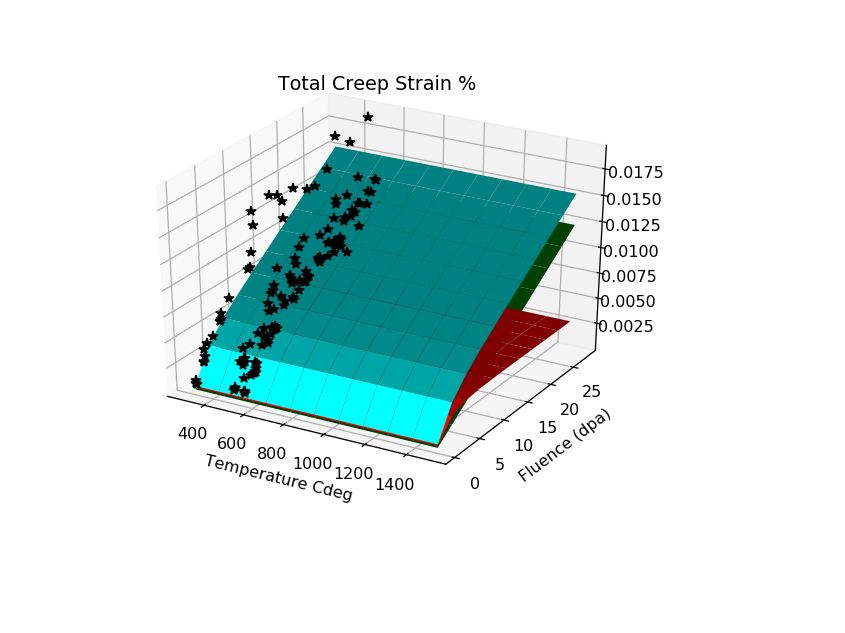

In [19]:
Temps = np.linspace(T.min(),T_Max_Plot,11)
Fluences = np.linspace(F.min(),F.max(),11)
TT,FF = np.meshgrid(Temps,Fluences)
r,c = TT.shape
Ep = np.zeros((r,c))
Es = np.zeros((r,c))
for i in range(r):
    
    Valid = np.array(TT == Temps[i])
    FVALID = FF[Valid]
    
    Fint,CP,CS = usnc.creepstrain(PCREEP,Temps[i],0,stress1,Ecp1,Ecs1,Temps[i],1.1*FVALID.max(),stress2,GetEcs,GetEcp,NumPointsCreepIntegration)
    
    CPinterp = interp1d(Fint, CP)    
    CSinterp = interp1d(Fint, CS)
    CPeval = CPinterp(FVALID)
    CSeval = CSinterp(FVALID)    
    Ep[Valid] = CPeval
    Es[Valid] = CSeval

ax10 = usnc.axis3d(100)
ax10.plot3D(T,F,Y,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('Total Creep Strain %')  
ax10.plot_surface(TT,FF,(Ep+Es),color='cyan')
ax10.plot_surface(TT,FF,Ep,color='red')
ax10.plot_surface(TT,FF,Es,color='green')
plt.show()

<IPython.core.display.Javascript object>


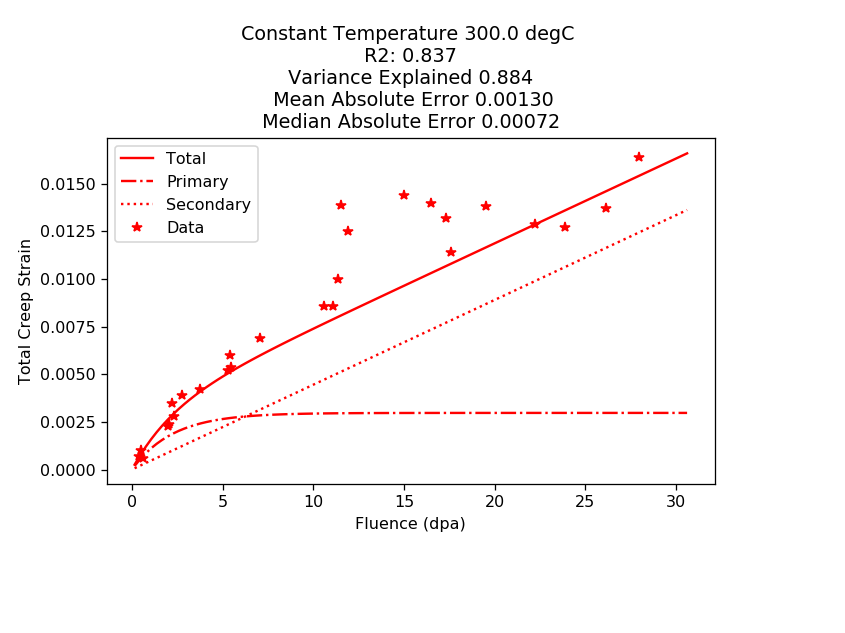

<IPython.core.display.Javascript object>


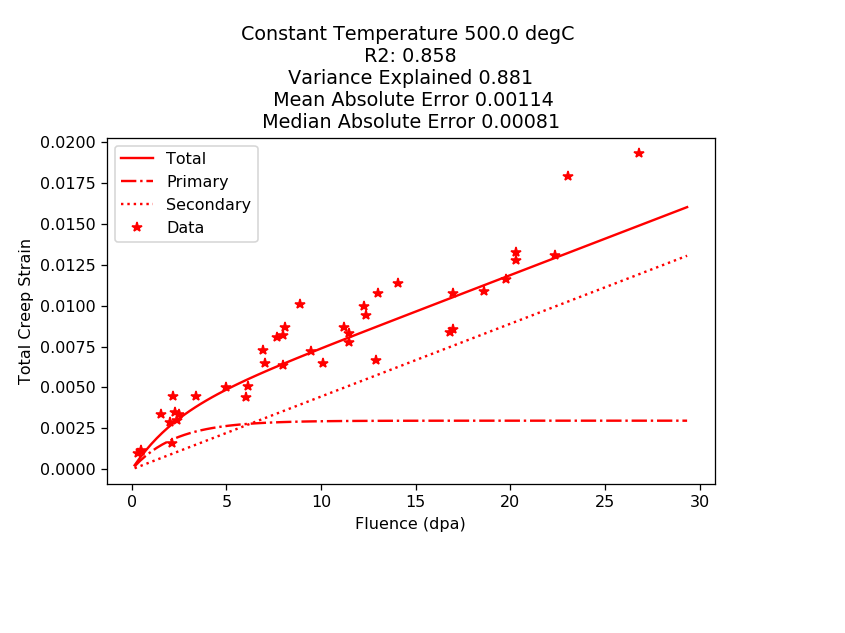

<IPython.core.display.Javascript object>


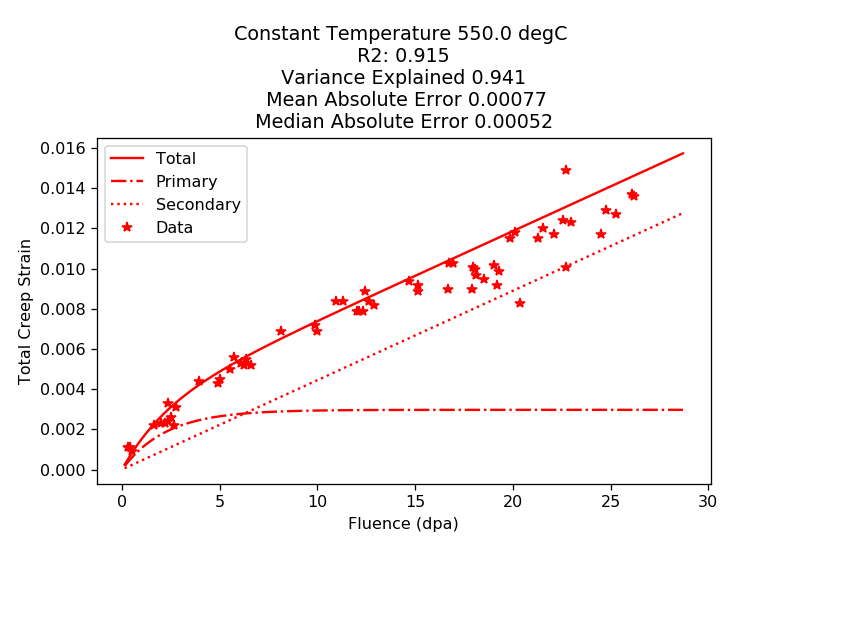

In [20]:
counter = 1000
for Temps in np.unique(T):
    plt.figure(counter)
    TFIX = Temps
    Valid = np.array(T == TFIX)
    FVALID = F[Valid]
    Fint,CP,CS = usnc.creepstrain(PCREEP,TFIX,0,stress1,Ecp1,Ecs1,TFIX,1.1*FVALID.max(),stress2,GetEcs,GetEcp,NumPointsCreepIntegration)
    CPinterp = interp1d(Fint, CP)    
    CSinterp = interp1d(Fint, CS)
    CPeval = CPinterp(FVALID)
    CSeval = CSinterp(FVALID)  

    plt.plot(Fint,CP+CS,'r-',label='Total');plt.xlabel('Fluence (dpa)');plt.ylabel('Total Creep Strain')
    plt.plot(Fint,CP,'r-.',label='Primary')
    plt.plot(Fint,CS,'r:',label='Secondary')
    plt.plot(FVALID,Y[Valid],'r*',label='Data')
    cod = r2_score(Y[Valid], CPeval+CSeval)
    ve = explained_variance_score(Y[Valid], CPeval+CSeval)
    mae = mean_absolute_error(Y[Valid], CPeval+CSeval)
    medae = median_absolute_error(Y[Valid], CPeval+CSeval)
    plt.title('Constant Temperature {} degC \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(TFIX,
        cod,ve,mae,medae))
    plt.tight_layout()
    plt.legend(loc='best')
    counter += 1

# Plot Control Scalar Functions

<IPython.core.display.Javascript object>


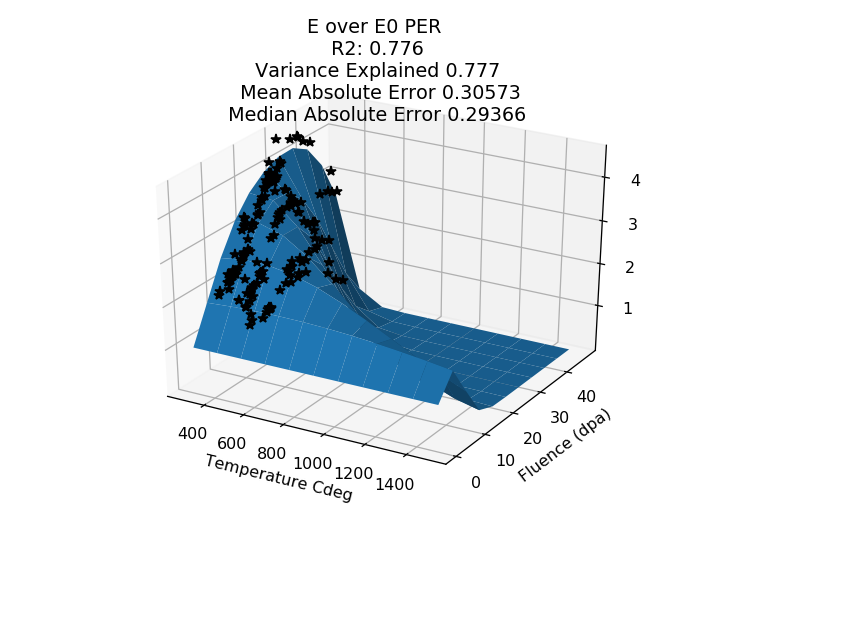

<IPython.core.display.Javascript object>


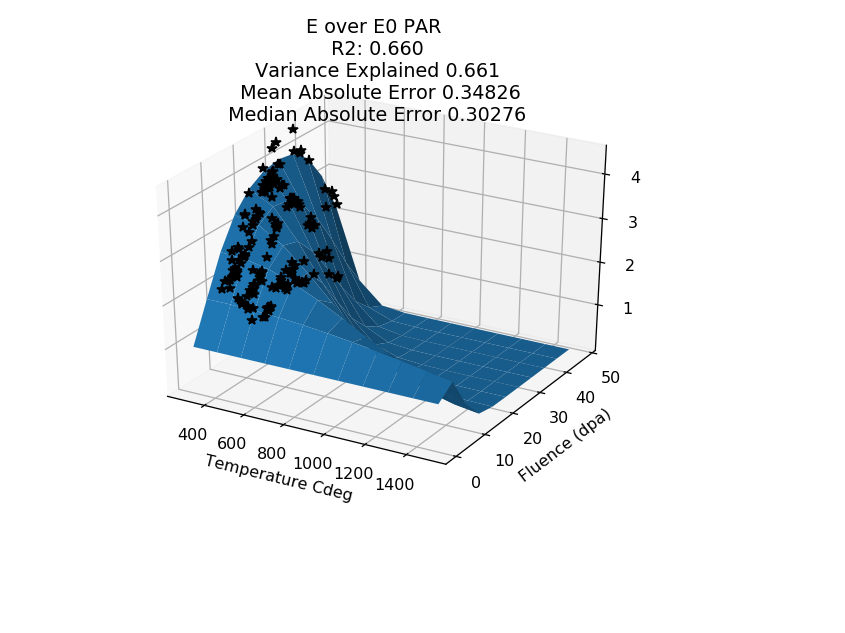

In [21]:

GRID = np.zeros((11,11))
# E over E0 along PER and PAR

ax10 = usnc.axis3d(1)
ax10.plot3D(tEE0per,fEE0per,EpE0per,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('E over E0 PER')  

######
#TT,FF = np.meshgrid(np.linspace(tEE0per.min(),tEE0per.max(),11),np.linspace(0.0,fEE0per.max(),11))
TT,FF = np.meshgrid(np.linspace(tEE0per.min(),T_Max_Plot,11),np.linspace(0.0,fEE0per.max(),11))

#####
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetEoverE0per(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

PredictY = []
t = np.array(tEE0per);f = np.array(fEE0per);myfunc = GetEoverE0per; YActual = np.array(EpE0per)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('E over E0 PER \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()

ax10 = usnc.axis3d(2)
ax10.plot3D(tEE0par,fEE0par,EpE0par,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('E over E0 PAR')  
#####
TT,FF = np.meshgrid(np.linspace(tEE0par.min(),tEE0par.max(),11),np.linspace(0.0,fEE0par.max(),11))
TT,FF = np.meshgrid(np.linspace(tEE0par.min(),T_Max_Plot,11),np.linspace(0.0,fEE0par.max(),11))

####
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetEoverE0par(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

PredictY = []
t = np.array(tEE0par);f = np.array(fEE0par);myfunc = GetEoverE0par; YActual = np.array(EpE0par)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('E over E0 PAR \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()

<IPython.core.display.Javascript object>


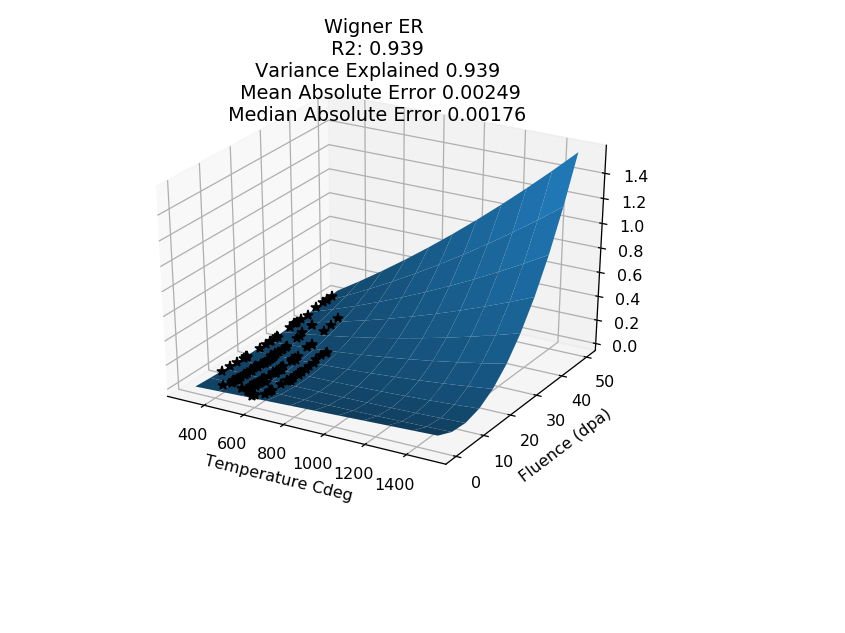

<IPython.core.display.Javascript object>


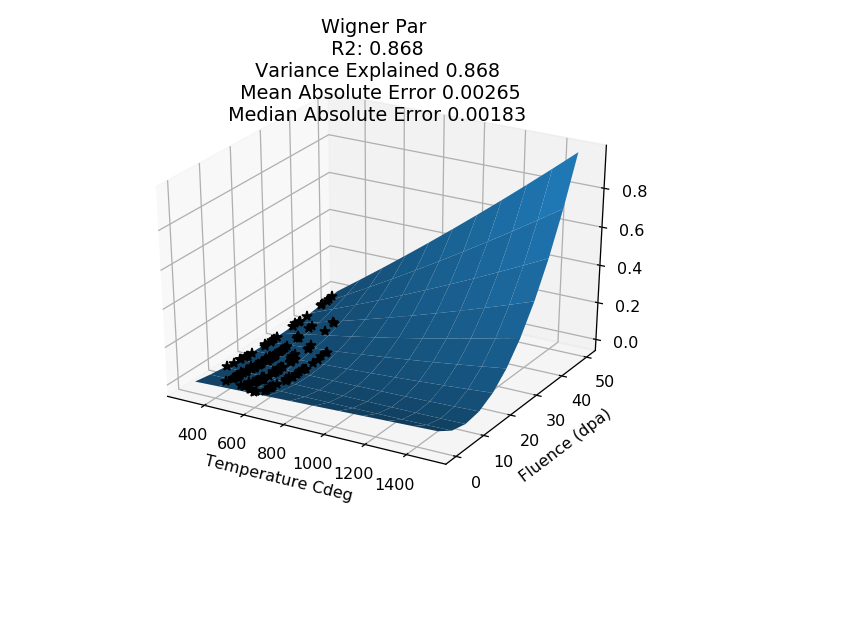

In [22]:
# DL along PER
ax10 = usnc.axis3d(5)
ax10.plot3D(tDLper,fDLper,YDLper,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('DL PER')  
GRID = np.zeros((11,11))
########
#TT,FF = np.meshgrid(np.linspace(tDLper.min(),tDLper.max(),11),np.linspace(0,fDLper.max(),11))
TT,FF = np.meshgrid(np.linspace(tDLper.min(),T_Max_Plot,11),np.linspace(0,50,11))

######
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetDLper(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tDLper);f = np.array(fDLper);myfunc = GetDLper; YActual = np.array(YDLper)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('Wigner ER \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()

# DL along PAR
ax10 = usnc.axis3d(6)
ax10.plot3D(tDLpar,fDLpar,YDLpar,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('DL PAR')  
GRID = np.zeros((11,11))
#######
#TT,FF = np.meshgrid(np.linspace(tDLpar.min(),tDLpar.max(),11),np.linspace(0,fDLpar.max(),11))
TT,FF = np.meshgrid(np.linspace(tDLpar.min(),T_Max_Plot,11),np.linspace(0,50,11))

#######
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetDLpar(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tDLpar);f = np.array(fDLpar);myfunc = GetDLpar; YActual = np.array(YDLpar)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('Wigner Par \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()

<IPython.core.display.Javascript object>


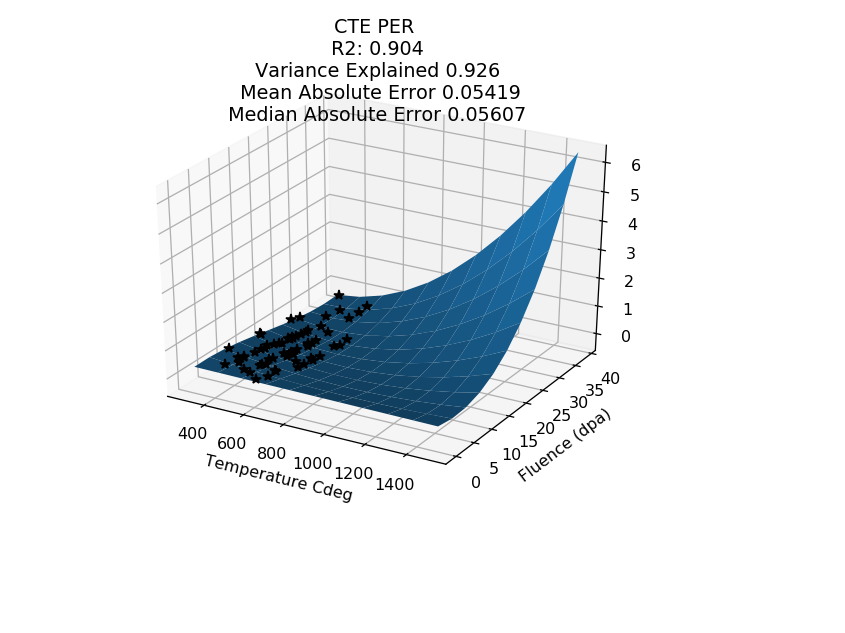

<IPython.core.display.Javascript object>


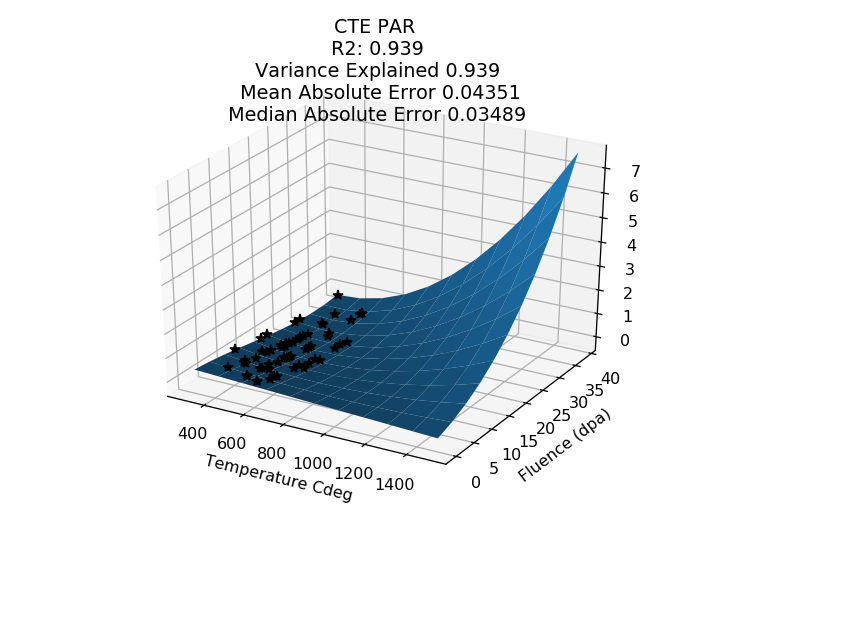

In [23]:
# CTE along PAR
ax10 = usnc.axis3d(8)
ax10.plot3D(tCTEoCTE0per,fCTEoCTE0per,YCTEoCTE0per,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('CTE PAR')  
GRID = np.zeros((11,11))
TT,FF = np.meshgrid(np.linspace(tCTEoCTE0per.min(),T_Max_Plot,11),np.linspace(0,fCTEoCTE0per.max(),11))
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetCTEoCTE0per(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tCTEoCTE0per);f = np.array(fCTEoCTE0per);myfunc = GetCTEoCTE0par; YActual = np.array(YCTEoCTE0per)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('CTE PER \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()

# CTE along PAR
ax10 = usnc.axis3d(9)
ax10.plot3D(tCTEoCTE0par,fCTEoCTE0par,YCTEoCTE0par,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('CTE PER')  
GRID = np.zeros((11,11))
TT,FF = np.meshgrid(np.linspace(tCTEoCTE0par.min(),T_Max_Plot,11),np.linspace(0,fCTEoCTE0par.max(),11))
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetCTEoCTE0par(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tCTEoCTE0par);f = np.array(fCTEoCTE0par);myfunc = GetCTEoCTE0par; YActual = np.array(YCTEoCTE0par)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(YActual, PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('CTE PAR \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
cod,ve,mae,medae))
plt.show()

<IPython.core.display.Javascript object>


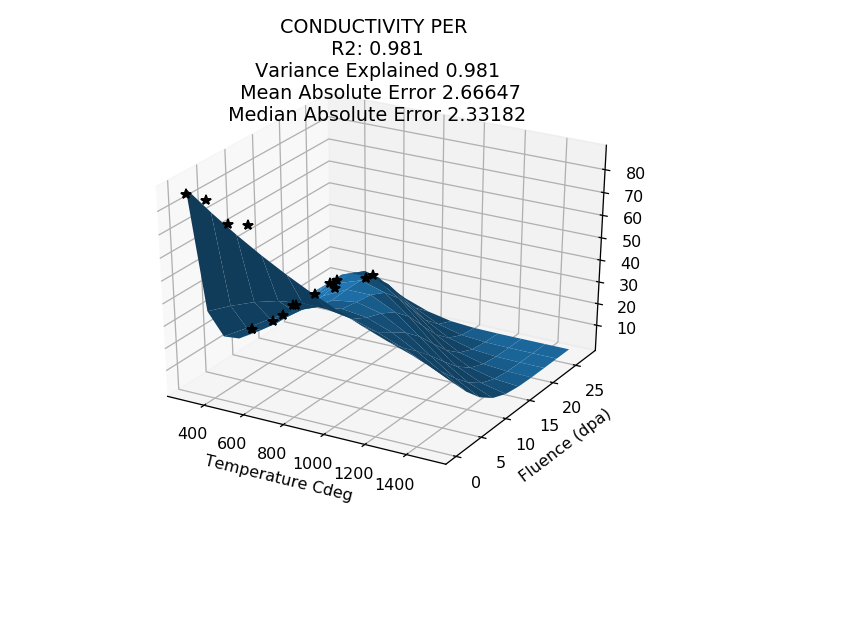

<IPython.core.display.Javascript object>


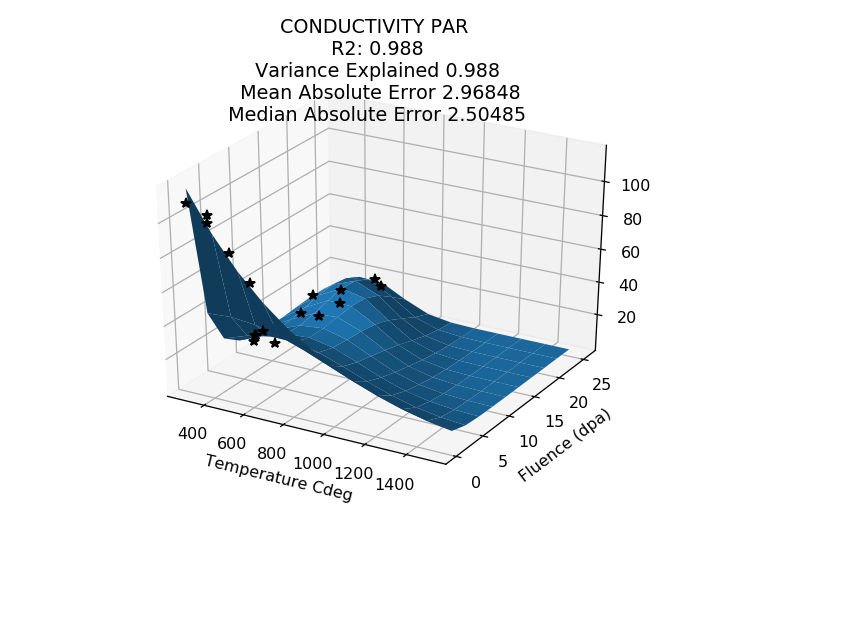

In [24]:
# CONDUCTIVITY along PER
ax10 = usnc.axis3d(10)
ax10.plot3D(tCONper,fCONper,np.array(CONper),'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('Conductivity PER')  
GRID = np.zeros((11,11))
TT,FF = np.meshgrid(np.linspace(tCONper.min(),T_Max_Plot,11),np.linspace(fCONper.min(),fCONper.max(),11))
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetCONper(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tCONper);f = np.array(fCONper);myfunc = GetCONper; YActual = np.array(CONper)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('CONDUCTIVITY PER \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))   
plt.show()

# CONDUCTIVITY along PAR
ax10 = usnc.axis3d(11)
ax10.plot3D(tCONpar,fCONpar,CONpar,'k*');plt.xlabel('Temperature Cdeg');plt.ylabel('Fluence (dpa)');plt.title('Conductivity PAR')  
GRID = np.zeros((11,11))
TT,FF = np.meshgrid(np.linspace(tCONpar.min(),T_Max_Plot,11),np.linspace(fCONpar.min(),fCONpar.max(),11))
for i in range(TT.shape[0]):
    for j in range(TT.shape[1]):
        GRID[i,j] = GetCONpar(TT[i,j],FF[i,j])
ax10.plot_surface(TT,FF,GRID)

# Generate and Plot Relevant Statistics
PredictY = []
t = np.array(tCONpar);f = np.array(fCONpar);myfunc = GetCONpar; YActual = np.array(CONpar)
for i in range(len(t)):
    PredictY.append(myfunc(t[i],f[i]))
cod = r2_score(np.array(YActual), PredictY)
ve = explained_variance_score(YActual, PredictY)
mae = mean_absolute_error(YActual, PredictY)
medae = median_absolute_error(YActual, PredictY)
plt.title('CONDUCTIVITY PAR \n R2: {:05.3f} \n Variance Explained {:05.3f} \n Mean Absolute Error {:05.5f}\n Median Absolute Error {:05.5f} '.format(
        cod,ve,mae,medae))
plt.show()